##################### Patrick L. Mthisi (patrickmthisi@hotmail.com)##############################

# Reject Inference Modelling using the Hard cutt-off metthod:

The dataset used in the project was sourced from: https://www.kaggle.com/code/shraddhacodes/credit-card-default-reject-inference-project/input.

About Dataset:

Please visit: https://python.plainenglish.io/a-project-on-reject-inference-94a6858bc821

# Objectives:

The project aims to develop a credit scorecard using data from all through-the-door credit customers. Among these customers, some have their credit applications rejected, resulting in a lack of information about their behavior at the time the scorecard is developed. Only the accepted clients have accumulated sufficient credit history, allowing us to label them as 'bad' or 'good' based on whether they have defaulted on their payments.

A straightforward approach to building a scorecard in this situation is to treat the rejects as Missing at Random (MAR) and to perform list-wise deletion of these cases. This means that the scorecard will be based solely on accepted applicants, who have a known good or bad status (referred to as the KGB sample). However, ignoring the rejected applications can introduce bias, as they usually represent a significant portion of the overall banking portfolio.

To address this issue, we can perform reject inference, which involves inferring the behavior of rejected applicants using the KGB model. Several techniques are available for this purpose, including Soft Augmentation, Fuzzy Augmentation, and Parcelling. The reader is encouraged to explore each of these methods. In this project, we will adopt the Simple Augmentation methodology.


This project delves into several important concepts and tools, including:  
- Automated explanatory data analysis utilizing Sweetviz.  
- Discretization of numerical features through OptBinning and subsequent transformation to the corresponding Weight of Evidence (WOE).  
- Determining the optimal threshold for flagging rejected samples.  
- Exploring a wide range of machine learning models to predict defaults.  

# Import libraries:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sweetviz
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, roc_curve, f1_score, recall_score 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline
from optbinning import BinningProcess
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
import glob
import os
import warnings
from collections import Counter

warnings.filterwarnings('ignore')

# user functions:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def corr(df, threshold, verbose=False):
    df = df.copy()
    df_numerical = df.select_dtypes(include=['float64', 'int64']).dropna()
    corr_matrix = df_numerical.corr()
    if verbose:
        matrix = np.triu(corr_matrix)
        plt.figure(figsize=(12, 7))
        sns.heatmap(corr_matrix[(corr_matrix > .5) & (corr_matrix < 1.0)], annot=True, vmin=-1.0, vmax=1.0, fmt='.2f', mask=matrix)
        plt.show()
        
    to_delete = set()
    columns = df_numerical.columns.to_list()
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            var1 = columns[i]
            var2 = columns[j]
            corr = corr_matrix.loc[var1, var2]
            if corr > threshold:
                to_delete.add(var1) 

    to_delete = list(to_delete)
    if verbose:
        print("Columns to delete due to high correlation:", to_delete)
    df = df.drop(columns=to_delete, axis=1)
    return df

def plot_performance_graphs(test_y, probs, test_y_pred):
    plt.figure(figsize=(10, 7))
    
    # Plot ROC
    plt.subplot(2, 2, 1)
    plot_auc_roc(test_y, probs)
    plt.title("ROC Curve")
    
    # Plot CAP
    plt.subplot(2, 2, 2)
    plot_cap(test_y, probs)
    plt.title("CAP Curve")
    
    # Plot KS Plot
    plt.subplot(2, 2, 3)
    plot_ks(test_y, probs)
    plt.title("KS Plot")
    
    # Plot Confusion Matrix
    plt.subplot(2, 2, 4)
    cm = confusion_matrix(test_y, test_y_pred)
    dataframe = pd.DataFrame(cm, index=[0, 1], columns=[0, 1])
    sns.heatmap(dataframe, annot=True, cbar=None, cmap="Greens", fmt='d')
    plt.title("Confusion Matrix")
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    
    plt.tight_layout()
    plt.show()


excel_files = glob.glob('*.xlsx')
print(excel_files)

['appbeh_rej.xlsx', 'appbeh_approved.xlsx']


# Load data:

In [2]:
df_accepted = pd.read_excel('appbeh_approved.xlsx', sheet_name='app_apprv', na_values=np.nan)
df_rejected = pd.read_excel('appbeh_rej.xlsx', sheet_name='app_rej', na_values=np.nan)

df_accepted['Type'] = 'Approved'
df_rejected['Type'] = 'Rejected'

print('Approved dataset summary:')
print(f'Approved dataset has {df_accepted.shape[0]} rows and {df_accepted.shape[1]} columns')

print('\nRejected dataset summary:')
print(f'Rejected dataset has {df_rejected.shape[0]} rows and {df_rejected.shape[1]} columns')

Approved dataset summary:
Approved dataset has 5252 rows and 41 columns

Rejected dataset summary:
Rejected dataset has 4749 rows and 41 columns


In [3]:
columns_to_keep = ['TAX_CODE', 
                   'AMT',
                   'ANNUAL_INCOME_AMT', 
                   'EDUCATION',
                   'EMP_YR_CNT',
                   'GENDER',
                   'MARITAL_STATUS', 
                   'RESIDENCE',
                   'EMPLOYMENT_STATUS_CD',
                   'TGT_VAR', 
                   'TOT_OUTSTANDING_31_60_DAY_AMT',
                   'SLN_DR_TRNS_LST_3M_CNT'] + [column for column in df_accepted.columns if column.startswith(('APPL', 'ACC'))]

df_appr_pop = df_accepted[columns_to_keep]
df_rej_pop = df_rejected[columns_to_keep]

# Perform explanatory data analysis:

In [4]:
os.makedirs('Reports', exist_ok=True)
appr_rej_report = sweetviz.compare(df_appr_pop, df_rej_pop)
appr_rej_report.show_html('Reports/appr_rej_report.html')

                                             |                                                                …

Report Reports/appr_rej_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
>4;1H84l=                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [5]:
num_cat_columns = ['TAX_CODE', 
                   'APPL_PCL_TYP_CD',
                   'APPL_PA_LEG_JUDG_FLG',
                   'APPL_PA_BNKR_STS_CD',
                   'APPL_PA_MNTS_FLG', 
                   'APPL_OUTCM_CD',
                   'APPL_PA_BUR1_BNKP_CNT',
                   'APPL_PA_BUR2_BNKP_CNT', 
                   'SLN_DR_TRNS_LST_3M_CNT', 
                   'ACC_1_30DLQ_LST_3M_CNT', 
                   'ACC_31_60DLQ_LST_3M_CNT', 
                   'ACC_61_90DLQ_LST_3M_CNT', 
                   'ACC_91_120DLQ_LST_3M_CNT', 
                   'ACC_DLD_PAY_LST_3M_CNT']
for col in num_cat_columns:
    df_appr_pop.loc[:, col] = df_appr_pop.loc[:, col].astype('object')
    df_rej_pop.loc[:, col] = df_rej_pop.loc[:, col].astype('object')

# Train and evaluate disbursed base models: 
## Models trained and evaluated on approved clients (known Goods and Bads):

In [6]:
seed = 42
c_map = [f"{c[0]}: {c[1]}" for c in enumerate(df_appr_pop.columns)]
c_map

['0: TAX_CODE',
 '1: AMT',
 '2: ANNUAL_INCOME_AMT',
 '3: EDUCATION',
 '4: EMP_YR_CNT',
 '5: GENDER',
 '6: MARITAL_STATUS',
 '7: RESIDENCE',
 '8: EMPLOYMENT_STATUS_CD',
 '9: TGT_VAR',
 '10: TOT_OUTSTANDING_31_60_DAY_AMT',
 '11: SLN_DR_TRNS_LST_3M_CNT',
 '12: ACC_AMT',
 '13: ACC_1_30DLQ_LST_3M_CNT',
 '14: ACC_31_60DLQ_LST_3M_CNT',
 '15: ACC_61_90DLQ_LST_3M_CNT',
 '16: ACC_91_120DLQ_LST_3M_CNT',
 '17: ACC_DLD_PAY_LST_3M_CNT',
 '18: ACC_1_30DLQ_LST_3M_AMT',
 '19: ACC_61_90DLQ_LST_3M_AMT',
 '20: ACC_91_120DLQ_LST_3M_AMT',
 '21: APPL_SCR_NO',
 '22: ACC_APPL_PCL_VAL_AMT',
 '23: APPL_PCL_TYP_CD',
 '24: APPL_PA_HHD_INC_AMT',
 '25: APPL_PA_LQD_AST_AMT',
 '26: APPL_PA_REST_AMT',
 '27: APPL_PA_AST_OTH_AMT',
 '28: APPL_PA_LBL_REST_AMT',
 '29: APPL_PA_LEG_JUDG_FLG',
 '30: APPL_PA_BNKR_STS_CD',
 '31: APPL_PA_MNTS_FLG',
 '32: APPL_APPT_MAX_AGE_NO',
 '33: APPL_APPT_MAX_LBL_AMT',
 '34: APPL_OUTCM_CD',
 '35: APPL_PA_BUR1_BNKP_CNT',
 '36: APPL_PA_BUR2_BNKP_CNT',
 '37: APPL_PA_BUR1_CURR_LMT_AMT']

> lr PR AUC: 0.509, ROC AUC: 0.820
> svm PR AUC: 0.378, ROC AUC: 0.791
> rf PR AUC: 0.554, ROC AUC: 0.827
> gnb PR AUC: 0.515, ROC AUC: 0.822
> lda PR AUC: 0.509, ROC AUC: 0.820
> xgb PR AUC: 0.566, ROC AUC: 0.826
> knn PR AUC: 0.522, ROC AUC: 0.761

Sorted Results (by ROC AUC):
Model: rf, ROC AUC: 0.827
Model: xgb, ROC AUC: 0.826
Model: gnb, ROC AUC: 0.822
Model: lr, ROC AUC: 0.820
Model: lda, ROC AUC: 0.820
Model: svm, ROC AUC: 0.791
Model: knn, ROC AUC: 0.761

Best Model Performance Measures:


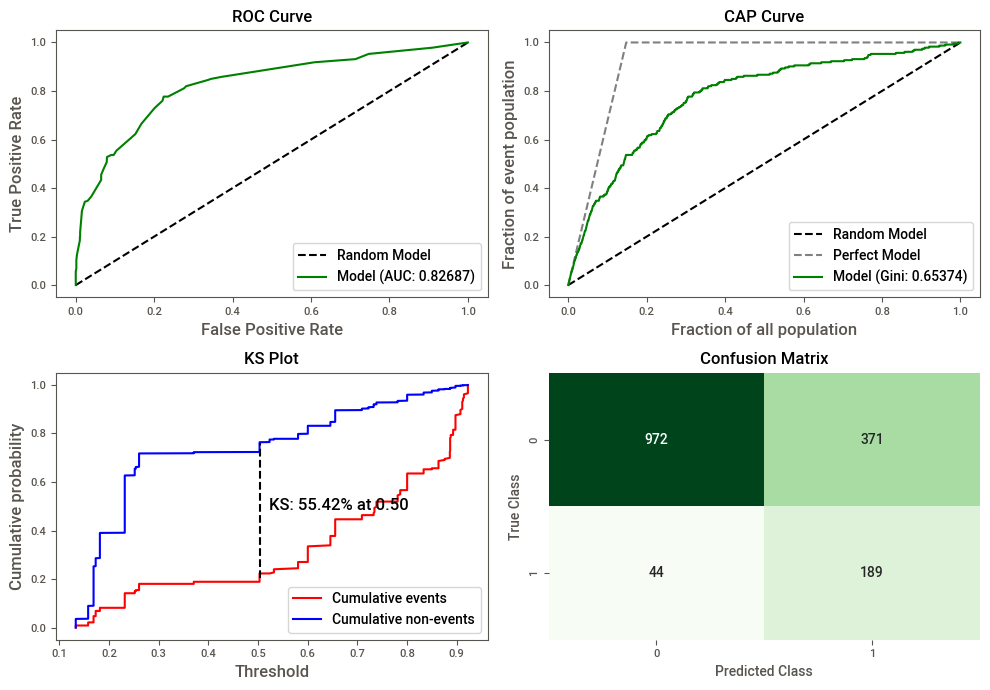

Recall for the Best Model: 0.811


In [7]:
def load_data(df, target_col, target_ix):
    ix = [i for i in range(df.shape[1]) if i != target_ix]
    X, y = df.iloc[:, ix], df.iloc[:, target_ix].values
    X = corr(X, .75, verbose=False)
    variable_names = list(X.columns.difference([target_col]))
    categorical_variables = list(X.select_dtypes(include=["object", "bool"]))
    y = LabelEncoder().fit_transform(y)
    return X, y, variable_names, categorical_variables

def evaluate_model(train_X, test_X, train_y, test_y, model):
    model.fit(train_X, train_y)
    yhat = model.predict_proba(test_X)
    model_probs = yhat[:, 1]
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(test_y, model_probs, labels=[0, 1])
    return pr_auc, roc_auc, model_probs
   
def load_models(models={}):
    models['lr'] = LogisticRegression(solver='lbfgs', random_state=seed)
    models['svm'] = CalibratedClassifierCV(SVC(gamma='scale', random_state=seed), method='sigmoid', cv=5)
    models['rf'] = CalibratedClassifierCV(RandomForestClassifier(random_state=seed), method='sigmoid', cv=5)
    models['gnb'] = GaussianNB()
    models['lda'] = LinearDiscriminantAnalysis()
    models['xgb'] = XGBClassifier()
    models['knn'] = CalibratedClassifierCV(KNeighborsClassifier(), method='sigmoid', cv=5)
    return models

# load data
X, y, variable_names, categorical_variables = load_data(df_appr_pop, target_col='TGT_VAR', target_ix=9)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

models = load_models()
evaluation_results = []

for name, model in models.items():
    selection_criteria = {"iv": {"min": 0.025, "max": 1.0}, "gini": {"min": 0.1}}

    binning_process = BinningProcess(variable_names=variable_names, 
                                     categorical_variables=categorical_variables,
                                     selection_criteria=selection_criteria)
    
    sampling = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
    
    steps = []
    steps.append(('binning', binning_process))
    steps.append(('sampling', sampling))
    steps.append(('clf', model))
    pipeline = Pipeline(steps=steps)
    
    pr_auc, roc_auc, model_probs = evaluate_model(train_X, test_X, train_y, test_y, pipeline)
    
    evaluation_results.append({'model': name, 'pr_auc': pr_auc, 'roc_auc': roc_auc, 'probs': model_probs, 'clf': pipeline})
    print(f'> {name} PR AUC: {pr_auc:.3f}, ROC AUC: {roc_auc:.3f}')

sorted_results = sorted(evaluation_results, key=lambda x: x['roc_auc'], reverse=True)

print('\nSorted Results (by ROC AUC):')
for result in sorted_results:
    print(f"Model: {result['model']}, ROC AUC: {result['roc_auc']:.3f}")
    
best_model = sorted_results[0]
probs = best_model['probs']
test_y_pred = best_model['clf'].predict(test_X)

print('\nBest Model Performance Measures:')
plot_performance_graphs(test_y, probs, test_y_pred)

default_class_coverage = recall_score(test_y, test_y_pred, pos_label=1, average='binary')
print(f'Recall for the Best Model: {default_class_coverage:.3f}')

del pr_auc, roc_auc, model_probs, sorted_results, probs, evaluation_results, binning_process

# Find the optimal rejection threshold using the best model:

Best Threshold=0.734, F-measure=0.531


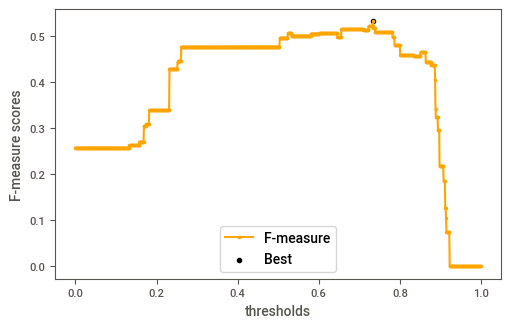

In [8]:
probs = best_model['probs']

thresholds = np.arange(0, 1, 0.001)
scores = [f1_score(test_y, to_labels(probs, t)) for t in thresholds]
ix = np.argmax(scores)
print(f'Best Threshold={thresholds[ix]:.3f}, F-measure={scores[ix]:.3f}')

plt.figure(figsize=(5.75, 3.5))
plt.plot(thresholds, scores, label='F-measure', marker='.', color='orange')
plt.scatter(thresholds[ix], scores[ix], marker='o', color='black', label='Best')
plt.xlabel('thresholds')
plt.ylabel('F-measure scores')
plt.legend(loc='lower center')
plt.show()

# Perform reject inference using the best model and the optimal threshold:

In [9]:
X_reg, y_reg, _, _ = load_data(df_rej_pop, target_col='TGT_VAR', target_ix=9)

clf = best_model['clf']

y_reg_prob = clf.predict_proba(X_reg)[:, 1]

print("\nRejected Dataset with Infered/Fuzzy Default Probabilities:")
print(y_reg_prob[:5])

y_reg_label = to_labels(y_reg_prob, thresholds[ix])
print("\nRejected Dataset with Inferred Default Flag:")
print(y_reg_label[:5])


Rejected Dataset with Infered/Fuzzy Default Probabilities:
[0.86372429 0.89791622 0.15786794 0.91313918 0.50319856]

Rejected Dataset with Inferred Default Flag:
[1 1 0 1 0]


# Train final model on combined dataset and evaluate:
## Models are trained and evaluated using through-the-door customers:

> lr PR AUC: 0.325, ROC AUC: 0.787
> svm PR AUC: 0.295, ROC AUC: 0.768
> rf PR AUC: 0.451, ROC AUC: 0.807
> gnb PR AUC: 0.326, ROC AUC: 0.791
> lda PR AUC: 0.326, ROC AUC: 0.789
> xgb PR AUC: 0.452, ROC AUC: 0.810
> knn PR AUC: 0.427, ROC AUC: 0.787

Sorted Results (by ROC AUC):
Model: xgb, ROC AUC: 0.810
Model: rf, ROC AUC: 0.807
Model: gnb, ROC AUC: 0.791
Model: lda, ROC AUC: 0.789
Model: knn, ROC AUC: 0.787
Model: lr, ROC AUC: 0.787
Model: svm, ROC AUC: 0.768

Best Model Performance Measures:


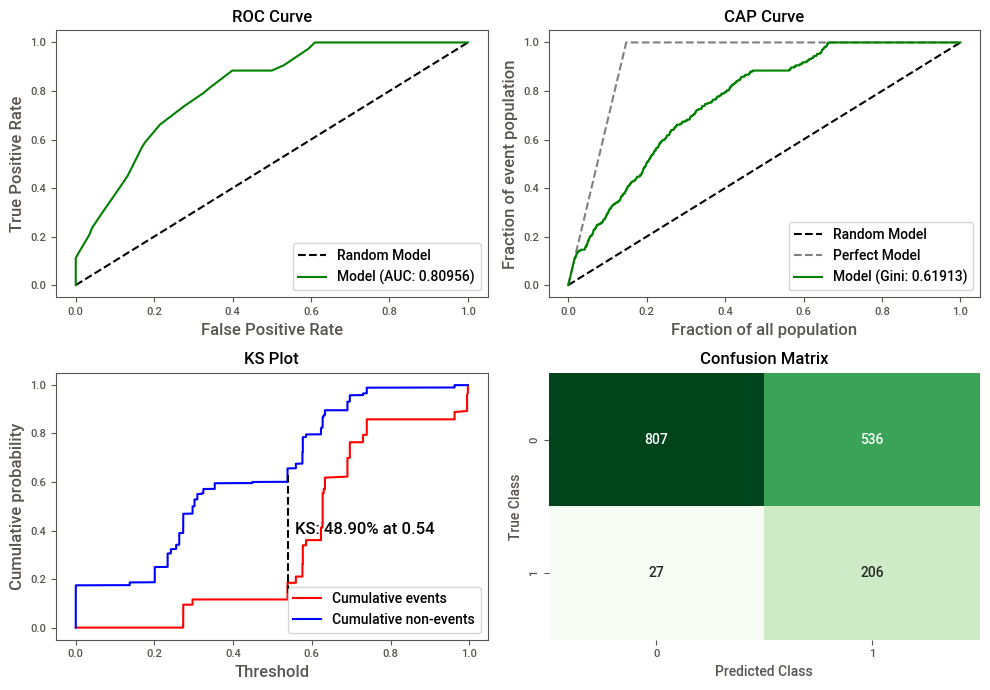

Recall for the Best Model: 0.884


In [10]:
X_combined = pd.concat([train_X, X_reg], ignore_index=True)
y_combined = pd.concat([pd.Series(train_y), pd.Series(y_reg_label)], ignore_index=True).values

variable_names = list(X_combined.columns)
categorical_variables = list(X_combined.select_dtypes(include=["object", "bool"]))

models = load_models()
evaluation_results = []

for name, model in models.items():
    selection_criteria = {"iv": {"min": 0.025, "max": 1.0}, "gini": {"min": 0.1}}

    binning_process = BinningProcess(variable_names=variable_names, 
                                     categorical_variables=categorical_variables,
                                     selection_criteria=selection_criteria)
    
    sampling = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
    
    steps = []
    steps.append(('binning', binning_process))
    steps.append(('sampling', sampling))
    steps.append(('clf', model))
    pipeline = Pipeline(steps=steps)
    
    pr_auc, roc_auc, model_probs = evaluate_model(X_combined, test_X, y_combined, test_y, pipeline)
    
    evaluation_results.append({'model': name, 'pr_auc': pr_auc, 'roc_auc': roc_auc, 'probs': model_probs, 'clf': pipeline})
    print(f'> {name} PR AUC: {pr_auc:.3f}, ROC AUC: {roc_auc:.3f}')
    
sorted_results = sorted(evaluation_results, key=lambda x: x['roc_auc'], reverse=True)

print('\nSorted Results (by ROC AUC):')
for result in sorted_results:
    print(f"Model: {result['model']}, ROC AUC: {result['roc_auc']:.3f}")
    
best_model = sorted_results[0]
probs = best_model['probs']
test_y_pred = best_model['clf'].predict(test_X)

print('\nBest Model Performance Measures:')
plot_performance_graphs(test_y, probs, test_y_pred)

default_class_coverage = recall_score(test_y, test_y_pred, pos_label=1, average='binary')
print(f'Recall for the Best Model: {default_class_coverage:.3f}')

del pr_auc, roc_auc, model_probs, sorted_results, probs, evaluation_results, binning_process

# Conclusion and recommendations:

In the end-to-end reject inference project, we applied the Simple Augmentation method, also known as the Hard Cut-off method. We trained a suite of machine learning models using known good and bad samples (KGB), ultimately identifying the extreme gradient boosting (XGB) model as the best performer, with an ROC AUC of 0.827 and a Gini coefficient of 0.654.

We determined an optimal threshold based on the highest F1 score and classified rejected customers as 'bad' or 'good' based on their default probability relative to this threshold. The rejected sample was combined with the KGB training sample to create a through-the-door dataset for further model training and evaluation.

The XGB model again proved to be the best, achieving ROC AUC and Gini scores of 0.810 and 0.619, respectively—only slightly different from the performance of the KGB model. Notably, the through-the-door model showed improved coverage of defaults, with a recall score of 0.884 compared to 0.811 for the KGB model.